# Bicing data cleaning
This notebook goes through the cleaning process of the Bicing usage dataset. 
You can find the source of the dataser here: https://opendata-ajuntament.barcelona.cat/data/en/dataset/estat-estacions-bicing

In [1]:
#Importing the required libraries
import pandas as pd
import seaborn as sns

In [44]:
octubre = pd.read_csv("..\\Dataset\\2019_10_Octubre_BicingNou_ESTACIONS.csv",encoding="utf_8")

In [46]:
#Checking how does the dataset look like
octubre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3655823 entries, 0 to 3655822
Data columns (total 13 columns):
station_id                              int64
num_bikes_available                     int64
num_bikes_available_types.mechanical    int64
num_bikes_available_types.ebike         int64
num_docks_available                     int64
is_installed                            int64
is_renting                              int64
is_returning                            int64
last_reported                           float64
is_charging_station                     bool
status                                  object
last_updated                            int64
ttl                                     int64
dtypes: bool(1), float64(1), int64(10), object(1)
memory usage: 338.2+ MB


In [47]:
octubre.head()

,station_id,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,is_installed,is_renting,is_returning,last_reported,is_charging_station,status,last_updated,ttl
0,1,25,24,1,4,1,1,1,1.569881e+09,True,IN_SERVICE,1569880820,30
1,2,12,11,1,15,1,1,1,1.569881e+09,True,IN_SERVICE,1569880820,30
2,3,19,19,0,8,1,1,1,1.569881e+09,True,IN_SERVICE,1569880820,30
3,4,15,15,0,3,1,1,1,1.569881e+09,True,IN_SERVICE,1569880820,30
4,5,35,35,0,3,1,1,1,1.569881e+09,True,IN_SERVICE,1569880820,30


In [45]:
octubre.isnull().sum()

station_id                              0
num_bikes_available                     0
num_bikes_available_types.mechanical    0
num_bikes_available_types.ebike         0
num_docks_available                     0
is_installed                            0
is_renting                              0
is_returning                            0
last_reported                           0
is_charging_station                     0
status                                  0
last_updated                            0
ttl                                     0
dtype: int64

In [48]:
#We want the columns "last_reported" and "last_updated" to be datetime. At the moment they are values in Unix Epoch time.
#In order to transform it, we should change the type from float to integer, and then to string (we want to make sure no .0)
octubre.last_reported = octubre.last_reported.astype(int)
octubre.last_reported = octubre.last_reported.astype(str)
octubre.last_updated = octubre.last_updated.astype(str)
octubre.dtypes


station_id                               int64
num_bikes_available                      int64
num_bikes_available_types.mechanical     int64
num_bikes_available_types.ebike          int64
num_docks_available                      int64
is_installed                             int64
is_renting                               int64
is_returning                             int64
last_reported                           object
is_charging_station                       bool
status                                  object
last_updated                            object
ttl                                      int64
dtype: object

In [51]:
#Transforming from Unix Epoch time to datetime
octubre.last_reported = pd.to_datetime(octubre.last_reported, unit = 's')
octubre.last_updated = pd.to_datetime(octubre.last_updated, unit = 's')

In [61]:
home = octubre.query('station_id== 381')

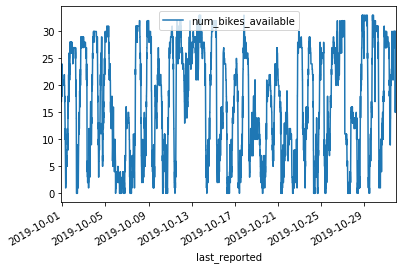

In [62]:
test = home[["last_reported","num_bikes_available"]]
test.plot(x='last_reported', y='num_bikes_available', style='-')


In [63]:
ironhack = octubre[octubre['station_id'] == 211]
test_ih = ironhack[["last_reported","num_bikes_available"]]
test_ih["last_reported"] = test_ih["last_reported"].astype(str)
test_ih_day = test_ih[test_ih["last_reported"].str.startswith('2019-10-18')]

C:\Users\jaume\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


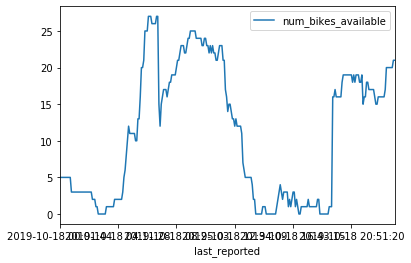

In [66]:
test_ih_day.plot(x='last_reported', y='num_bikes_available', style='-')

C:\Users\jaume\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


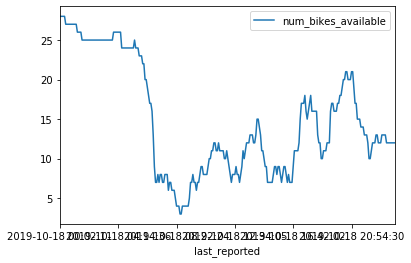

In [65]:
test["last_reported"] = test["last_reported"].astype(str)
test_day = test[test["last_reported"].str.startswith('2019-10-18')]
test_day.plot(x='last_reported', y='num_bikes_available', style='-')